In [1]:
import torch
import torchaudio
from pathlib import Path
import numpy as np
import pandas as pd
from collections import defaultdict
import random
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt



In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load pretrained ReDimNet (example config)
redim_model = torch.hub.load(
    "IDRnD/ReDimNet",
    "ReDimNet",
    model_name="b2",      # or b3/b5/etc.
    train_type="ptn",     # or "ft_lm"/"ft_mix" depending what you want
    dataset="vox2",       # typical pretraining dataset
).to(DEVICE).eval()

# # # Save model layers to a text file
# model_str = repr(redim_model)
# with open("model_architecture.txt", "w") as f:
#     f.write(model_str)


Using cache found in C:\Users\yoav1/.cache\torch\hub\IDRnD_ReDimNet_master


In [5]:
def embed_with_redim(wav_path: str) -> np.ndarray:
    wav, sr = torchaudio.load(wav_path)   # [C, T]
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, sr, 16000)
    if wav.shape[0] > 1:
        wav = wav[:1, :]                  # take first channel

    wav = wav.to(DEVICE)
    with torch.no_grad():
        emb = redim_model(wav)           # [1, 192]
    return emb.squeeze(0).cpu().numpy()       # [192]

In [6]:
DATA_DIR = Path("/home/amit/yoav_zucker/Models/data/team_wav")  # <-- change this

wav_files = sorted(DATA_DIR.glob("*.wav"))

rows = []
for p in wav_files:
    stem = p.stem          # e.g. "idan_001"
    speaker = stem.split("_")[0]
    rows.append({"file": str(p), "speaker": speaker})

df = pd.DataFrame(rows)
print(df.head())
print("Total files:", len(df))
print("Speakers:", df["speaker"].unique())

                                                file speaker
0  /home/amit/yoav_zucker/Models/data/team_wav/ed...    eden
1  /home/amit/yoav_zucker/Models/data/team_wav/ed...    eden
2  /home/amit/yoav_zucker/Models/data/team_wav/ed...    eden
3  /home/amit/yoav_zucker/Models/data/team_wav/ed...    eden
4  /home/amit/yoav_zucker/Models/data/team_wav/ed...    eden
Total files: 90
Speakers: ['eden' 'idan' 'yoav']


In [9]:

embs = []
for i, row in df.iterrows():
    vec = embed_with_redim(row["file"])
    embs.append(vec)

E = np.vstack(embs).astype("float32")  # [N, 192]
print("Embedding matrix shape:", E.shape)

# L2-normalize
E_norm = E / np.linalg.norm(E, axis=1, keepdims=True)


Embedding matrix shape: (90, 192)


In [10]:

GLOBAL_ENROLL_PER_SPK = 3 
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

groups = defaultdict(list)
for i, row in df.iterrows():
    groups[row["speaker"]].append(i)

enroll_idx = []
test_idx = []

for spk, idxs in groups.items():
    idxs = idxs.copy()
    random.shuffle(idxs)

    n_avail = len(idxs)
    if n_avail <= GLOBAL_ENROLL_PER_SPK:
        n_enroll = max(1, n_avail - 1)  # keep at least 1 test if we can
    else:
        n_enroll = GLOBAL_ENROLL_PER_SPK

    enroll_for_spk = idxs[:n_enroll]
    test_for_spk = idxs[n_enroll:]

    enroll_idx.extend(enroll_for_spk)
    test_idx.extend(test_for_spk)

enroll_idx = np.array(sorted(enroll_idx))
test_idx = np.array(sorted(test_idx))

print("Enrollment per speaker:", GLOBAL_ENROLL_PER_SPK)
print("Total enrollment files:", len(enroll_idx))
print("Total test files:", len(test_idx))


Enrollment per speaker: 3
Total enrollment files: 9
Total test files: 81


In [11]:

enroll_emb = E_norm[enroll_idx]
test_emb   = E_norm[test_idx]

enroll_labels = df.iloc[enroll_idx]["speaker"].to_numpy()
test_labels   = df.iloc[test_idx]["speaker"].to_numpy()

pred_labels = []

for e in test_emb:
    sims = cosine_similarity(e.reshape(1, -1), enroll_emb)[0]  # [N_enroll]
    best = np.argmax(sims)
    pred_labels.append(enroll_labels[best])

pred_labels = np.array(pred_labels)

accuracy = (pred_labels == test_labels).mean()
print(f"\nOverall accuracy: {accuracy:.4f}")



Overall accuracy: 1.0000


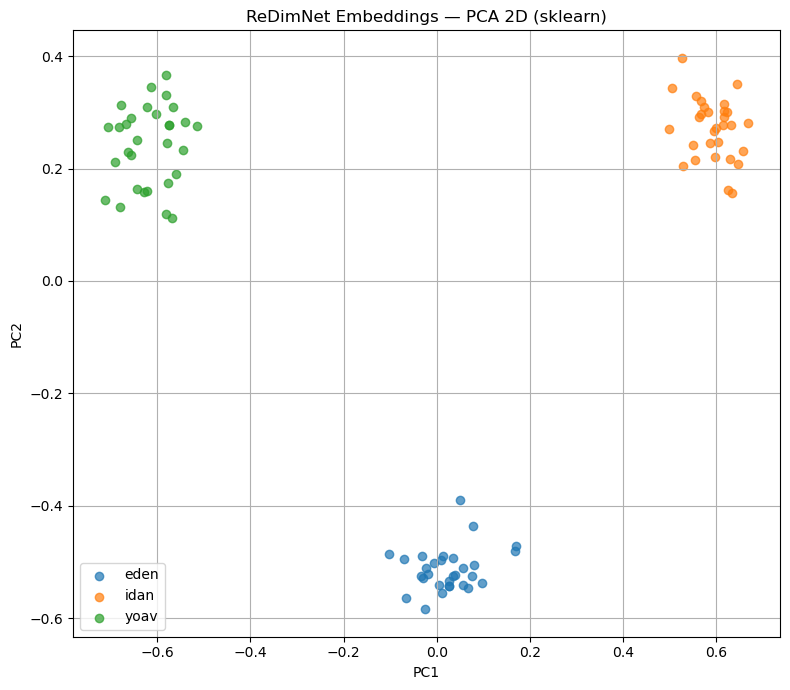

In [13]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Fit PCA on all embeddings
pca = PCA(n_components=3, random_state=0)
X_pca = pca.fit_transform(E_norm)   # shape [N, 3]

pca2d = X_pca[:, :2]   # first 2 PCs
pca3d = X_pca          # 3 PCs

speakers = df["speaker"].unique()

plt.figure(figsize=(8, 7))

for spk in speakers:
    idx = (df["speaker"] == spk)
    plt.scatter(pca2d[idx, 0], pca2d[idx, 1], alpha=0.7, label=spk)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("ReDimNet Embeddings — PCA 2D (sklearn)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



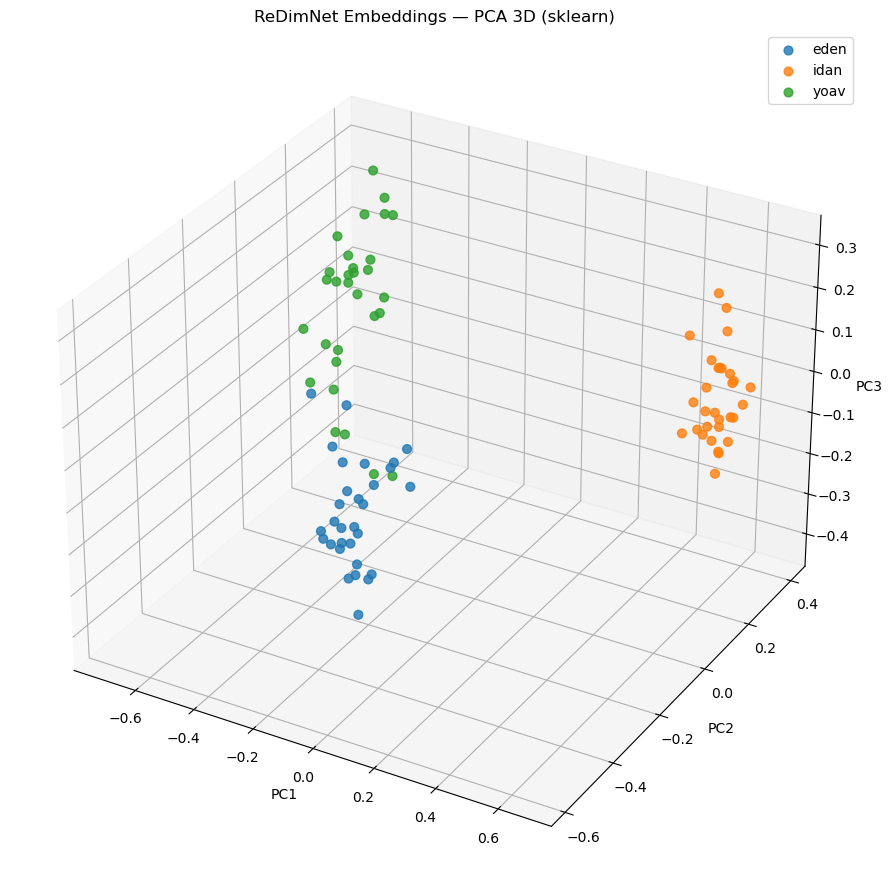

In [14]:
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection

fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection="3d")

for spk in speakers:
    idx = (df["speaker"] == spk)
    ax.scatter(
        pca3d[idx, 0],
        pca3d[idx, 1],
        pca3d[idx, 2],
        s=40,
        alpha=0.8,
        label=spk,
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("ReDimNet Embeddings — PCA 3D (sklearn)")
ax.legend()
plt.tight_layout()
plt.show()
